## Problem Statement
Text Classification is a main problem in NLP. Solving it relays to the Homonyms in the sentence and how to overcome this problem we faced in sentimental analysis and the contextual problems.

**Table of Content**

*   VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
*   Bert Pretrained Model from 🤗
*   Fine Tuning distilbert on GLUE Dataset
* Fine Tuning on Generated Data by ChatGPT



## Step 1. VADER Seniment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.



*  This uses a "bag of words" approach:

1.   Stop words are removed
2.   each word is scored and combined to a total score.







In [ ]:
import nltk

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I hate the selfishness in you')

{'neg': 0.681, 'neu': 0.319, 'pos': 0.0, 'compound': -0.7506}

In [ ]:
sia.polarity_scores('I hate any one who can hurt you')

{'neg': 0.587, 'neu': 0.413, 'pos': 0.0, 'compound': -0.7964}

**IT DIDN'T WORK** 🙃

## Step 2. The Transformers Pipeline
*   Quick & easy way to run sentiment predictions

*   Hint : By default, the model downloaded for this pipeline is called "distilbert-base-uncased-finetuned-sst-2-english"




In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

Classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
results = Classifier(["I hate any one who can hurt you.",
           "I hate the selfishness in you."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9823
label: NEGATIVE, with score: 0.9936


**IT DIDN'T WORK** 🙃

In [ ]:
Classifier('I hate any one who can hurt you because I care about you')

[{'label': 'POSITIVE', 'score': 0.9856659770011902}]

## Step 3. Bert Pretrained Model

*   Use a model trained of a large corpus of data.

*   Transformer model accounts for the words but also the context related to other words.




In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
# Instantiate Model
MODEL = f"nickwong64/bert-base-uncased-poems-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [ ]:
# Run for Bert Model (encode and calculate the sentence)
text = 'I hate the selfishness in you.'
output = classifier(text)

scores = output[0]['score']
scores_dict = {
    'Positive': 1 - scores,
    'Negative': scores,
}
print(scores_dict)

{'Positive': 0.09736460447311401, 'Negative': 0.902635395526886}


**IT DIDN'T WORK** 🙃

## Step 4. Fine Tuning on GLUE Dataset
I will fine tune the DistlBert on GLUE dataset on sst2 task

In [1]:
!pip install transformers datasets

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import pandas as pd

# Load the GLUE dataset for sentiment analysis
from datasets import load_dataset
dataset = load_dataset("glue", "sst2")

### Understanding the Dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [ ]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


In [ ]:
def label_converter(row):
  return dataset["train"].features["label"].int2str(row)

In [ ]:
df["label_name"]=df["label"].apply(label_converter)
df.head()

,sentence,label,idx,label_name
0,hide new secretions from the parental units,0,0,negative
1,"contains no wit , only labored gags",0,1,negative
2,that loves its characters and communicates som...,1,2,positive
3,remains utterly satisfied to remain the same t...,0,3,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,4,negative


### Data Visualization

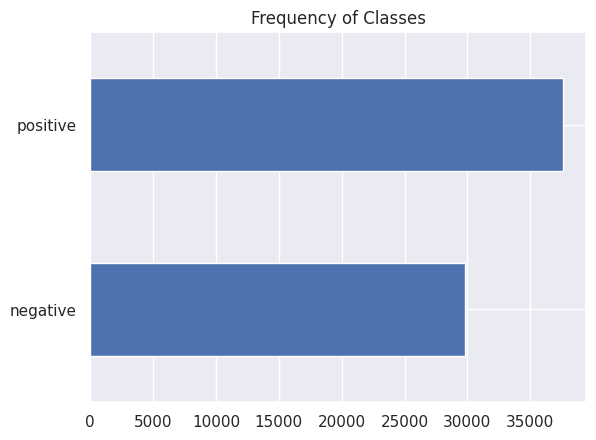

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
dataset.reset_format()

### Tokenization

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [ ]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(batch):
  return tokenizer(batch["sentence"], padding = True, truncation = True)

In [ ]:
tokenized_datasets = dataset.map(tokenize_function,
                                  batched = True,
                                  batch_size = None)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

### Modeling

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

model = "distilbert-base-uncased-finetuned-sst-2-english"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(model,
                                                            num_labels = 2).to(device))


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "finetuning-SentimentAnalysis-model",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm= False,
    push_to_hub = True
)

### Training

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer
)

Cloning https://huggingface.co/MahmoudMohsen/finetuning-SentimentAnalysis-model into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.057500,0.295252,0.907110,0.906985
2,0.032800,0.375457,0.902523,0.902355


TrainOutput(global_step=2106, training_loss=0.04440738468767911, metrics={'train_runtime': 819.9912, 'train_samples_per_second': 164.268, 'train_steps_per_second': 2.568, 'total_flos': 2300086292646384.0, 'train_loss': 0.04440738468767911, 'epoch': 2.0})

In [ ]:
# Saving The Model
trainer.save_model('senti_analysis')

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Aug07_23-25-06_ee996ebaf5ea/events.out.tfevents.1691450711.ee996ebaf5ea.2639.0:   0%|        …

To https://huggingface.co/MahmoudMohsen/finetuning-SentimentAnalysis-model
   524b90c..5100375  main -> main

   524b90c..5100375  main -> main

To https://huggingface.co/MahmoudMohsen/finetuning-SentimentAnalysis-model
   5100375..7aa875d  main -> main

   5100375..7aa875d  main -> main



In [ ]:
trainer.push_to_hub(commit_message = "Training completed")

### Prediction

In [2]:
from transformers import pipeline

Classifier = pipeline("sentiment-analysis",
                      model="MahmoudMohsen/finetuning-SentimentAnalysis-model")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [3]:
results = Classifier(["I hate any one who can hurt you.",
                      "I hate the selfishness in you."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9283
label: NEGATIVE, with score: 0.992


**IT DIDN'T WORK** 🙃

# Step 5. Fine Tuning on Generated Data by ChatGPT

In [2]:
# Step 1: Load and preprocess the dataset from the txt file
import pandas as pd

data_path = "/content/Generated Data.txt"

Generated_Data = pd.read_csv(data_path)
Generated_Data.head()

,Sentence,Label
0,I hate the selfishness in you.,negative
1,I hate anyone who can hurt you.,positive
2,Her smile brightens my day.,positive
3,The weather is gloomy and depressing.,negative
4,"He's so annoying, always interrupting.",negative


### EDA

In [3]:
Generated_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269 entries, 0 to 2268
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2269 non-null   object
 1   Label     2269 non-null   object
dtypes: object(2)
memory usage: 35.6+ KB


In [4]:
# Shuffle the data
Generated_Data = Generated_Data.sample(frac=1, random_state=42).reset_index(drop=True)
Generated_Data.sample(15)

,Sentence,Label
502,Her pessimistic outlook taints the team's pote...,negative
1322,Her dismissive attitude towards differing opin...,negative
2014,I'm disheartened by her pessimistic perspectiv...,negative
889,Her positive energy uplifts those around her.,positive
368,Encouraging open dialogue promotes understandi...,positive
810,I can't forgive his betrayal.,negative
197,I'm inspired by his determination to overcome ...,positive
824,The feeling of accomplishment is exhilarating.,positive
945,I'm frustrated by her tendency to undermine th...,negative
393,Cynical remarks create a toxic atmosphere.,negative


In [5]:
Generated_Data.duplicated("Sentence").sum()

639

In [6]:
Generated_Data.drop_duplicates(subset="Sentence", inplace=True)

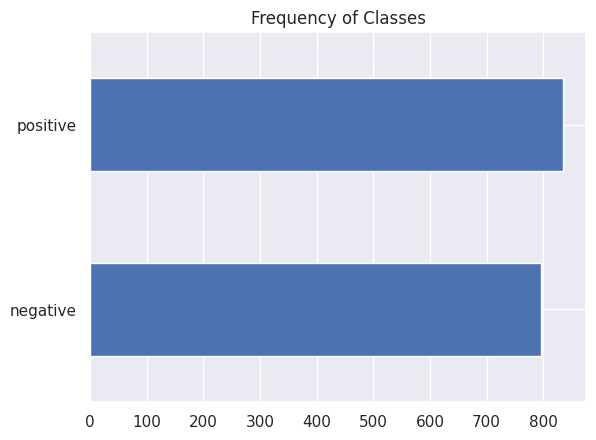

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

Generated_Data["Label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### Tokenization

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

In [9]:
sentences = Generated_Data["Sentence"].tolist()
labels = Generated_Data["Label"].tolist()

In [10]:
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

In [11]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, numerical_labels, test_size=0.2, random_state=42)

In [12]:
# Step 2: Tokenization
from datasets import Dataset
model_name = "MahmoudMohsen/finetuning-SentimentAnalysis-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Convert your data to a Hugging Face Dataset format
train_dataset = Dataset.from_dict({"sentence": train_sentences, "label": train_labels})
val_dataset = Dataset.from_dict({"sentence": val_sentences, "label": val_labels})

In [13]:
def tokenize_function(batch):
    return tokenizer(batch["sentence"], padding=True, truncation=True)

In [14]:
# Tokenize datasets
tokenized_train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=None,
)
tokenized_val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=None,
)

Map:   0%|          | 0/1304 [00:00<?, ? examples/s]

Map:   0%|          | 0/326 [00:00<?, ? examples/s]

### Modeling

In [15]:
from transformers import AutoModelForSequenceClassification
import torch

model = "MahmoudMohsen/finetuning-SentimentAnalysis-model"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(model,
                                                            num_labels = 2).to(device))


In [16]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [17]:
from huggingface_hub import notebook_login
notebook_login()

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "finetuning-HomonymsSentimentAnalysis-model",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm= False,
    push_to_hub = True
)

### Training

In [20]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_val_dataset,
    tokenizer = tokenizer
)

Cloning https://huggingface.co/MahmoudMohsen/finetuning-HomonymsSentimentAnalysis-model into local empty directory.


In [21]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.056819,0.987730,0.987738
2,No log,0.057029,0.990798,0.990800


TrainOutput(global_step=42, training_loss=0.017348915338516235, metrics={'train_runtime': 11.3492, 'train_samples_per_second': 229.795, 'train_steps_per_second': 3.701, 'total_flos': 19567918545216.0, 'train_loss': 0.017348915338516235, 'epoch': 2.0})

In [22]:
# Saving The Model
trainer.save_model('Homonyms_sentiment_analysis')

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

Upload file runs/Aug14_14-54-18_e96fa6690ea2/events.out.tfevents.1692024917.e96fa6690ea2.7334.0:   0%|        …

To https://huggingface.co/MahmoudMohsen/finetuning-HomonymsSentimentAnalysis-model
   ac96376..d16d7ad  main -> main

   ac96376..d16d7ad  main -> main

To https://huggingface.co/MahmoudMohsen/finetuning-HomonymsSentimentAnalysis-model
   d16d7ad..57debb5  main -> main

   d16d7ad..57debb5  main -> main



In [23]:
trainer.push_to_hub(commit_message = "Training completed")

### Prediction

In [24]:
from transformers import pipeline

Classifier = pipeline("sentiment-analysis",
                      model="MahmoudMohsen/finetuning-HomonymsSentimentAnalysis-model")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [29]:
results = Classifier(["I hate any one who can hurt you.",
                      "I hate the selfishness in you."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: NEGATIVE, with score: 0.9989
label: NEGATIVE, with score: 0.9995


**IT DIDN'T WORK ALSO** 🙃
I think there is something wrong 🤔